#### Mô tả phương pháp dự kiến
    Do phương pháp cũ còn một số hạn chế như lượng data cần sử dụng để train model là tương đối lớn, độ chính xác chưa thực sự cao và đặc biệt là model đã train không thể thêm được khuôn mặt mới để nhận dạng nên nhóm 20 đã thử nghiên cứu phương pháp nhận dạng mới, sử dụng InsightFaceAPI. 
    Nếu như phương pháp cũ sử dụng model đã train để đối chiếu sau giai đoạn trích lọc đặc trưng thì ở phương pháp mới, InsightFace được sự dụng để trích lọc đặc trưng của mỗi khuôn mặt, sau đó lưu thành các Vecto gồm 512 trường, là các tham số. Các vecto của các khuôn mặt đã nhận dạng được lưu vào database, và khi có khuôn mặt mới cần được dự đoán, khuôn mặt mới đó cũng sẽ được trích thành vecto rồi sau đó, chúng tôi sử dụng thuật toán tìm kiếm Tương đồng Cosine để tìm ra khuôn mặt có sự tương đồng lớn nhất.    
Phương pháp mới sẽ có ưu điểm là nhanh hơn, yêu cầu sử dụng ít phần cứng hơn để train model, tuy nhiên cũng sẽ có 1 nhược điểm nhỏ là khó cài đặt do thư viện InsightFace là một API có sẵn và đòi hỏi sự tương thích cao

hon



In [20]:
import os
import cv2
import numpy as np
import pandas as pd

from insightface.app import FaceAnalysis

In [21]:
#Load models buffalo_sc, đây là model tương đối nhẹ trong thư viện insightface và vẫn đảm bảo được độ chính xác cao
faceapp = FaceAnalysis(name='buffalo_sc',
                       root='insightface_model',
                       providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5) 
#warning:không nên đặt ngưỡng phát hiện khuôn mặt (det_thresh) dưới 0.3, vì có thể dẫn đến nhiều khuôn mặt giả được phát hiện, ảnh hưởng đến độ chính xác

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_sc\det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_sc\w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


#### Trích đặc trưng khuôn mặt và gán nhãn

In [22]:
#Hàm clean_name giúp thống nhất lại các đặt tên cho đối tượng được quét mặt
import re # redular expression
def  clean_name(string):
    #Allow only alphabet
    string = re.sub(r'[^A-Za-z]',' ', string)
    string = string.title()
    return string

In [23]:
#Khởi tạo một danh sách trống để lưu trữ thông tin về từng người nổi tiếng trong folder images
person_info=[]
listdir=os.listdir(path='images')

for folder_name in listdir:
    role, name = folder_name.split('-')
    name = clean_name(name)
    role = clean_name(role)

    #Lấy danh sách các tệp hình ảnh trong thư mục con hiện tại.
    img_files = os.listdir(path=f'images/{folder_name}')
    for file in img_files:
        path=f'./images/{folder_name}/{file}'
        # bước 1: đọc hình ảnh
        img_arr = cv2.imread(path)
        
        # nước 2: lấy thông tin
        result= faceapp.get(img_arr, max_num=1) #return lại list
        if len(result)>0: #Kiểm tra xem có khuôn mặt được phát hiện hay không.
            # bước 3: trích xuất ra đặc trưng dưới dạng tham số
            res=result[0]
            # print(res.keys())
            embedding = res['embedding']
            
            # bước 4: Thêm thông tin về người (tên, vai trò, đặc trưng khuôn mặt) vào danh sách person_info
            person_info.append([name,role, embedding])

        
    

In [24]:
#dataframe dưới đây được tạo từ danh sách person_info, với các cột là 'Name', 'Role' và 'Facial_Features'
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])
dataframe

,Name,Role,Facial_Features
0,Angelina Jolie,Student,"[-0.8410335, 1.6623635, -0.745449, -2.138221, ..."
1,Angelina Jolie,Student,"[0.09012404, -0.4169108, -0.37650695, 0.424011..."
2,Angelina Jolie,Student,"[0.86389506, 0.32952017, 0.05781859, -1.453824..."
3,Angelina Jolie,Student,"[1.6630238, 1.161926, -0.4108489, -2.6416948, ..."
4,Angelina Jolie,Student,"[0.864314, 0.9437618, 0.4265172, -1.1836909, -..."
5,Angelina Jolie,Student,"[0.40983105, 1.1813736, -0.9961994, -1.4018284..."
6,Angelina Jolie,Student,"[0.42182076, 2.0830736, 1.0647428, -2.273447, ..."
7,Angelina Jolie,Student,"[0.3949412, 0.84420955, -0.615458, -2.105093, ..."
8,Angelina Jolie,Student,"[1.0928565, 1.1707087, -0.2880756, -2.0103226,..."
9,Angelina Jolie,Student,"[-0.63545597, 1.7897248, 0.5982856, -3.550097,..."


Sau khi trích chọn đặc trưng 10 hình ảnh cho 10 nhân vật, công đoạn tiếp theo sẽ là test xem model có nhận diện được khuôn mặt từ file test không
### bước 1: Đọc hình ảnh từ file test (file test có khuôn mặt khác với các file đã được đọc ở trên

In [25]:
img_test =  cv2.imread('test_images/test_2.jpeg')
cv2.imshow('test image', img_test)
cv2.waitKey(0)
cv2.destroyAllWindows()


### bước 2: Trích chọn đặt trưng

In [26]:
res_test = faceapp.get(img_test, max_num=0)
#vòng lặp được sử dụng để phát hiện nhiều hơn 1 khuôn mặt trong 1 ảnh
for i, rt in enumerate(res_test):
    print('current loop =',i)
    bbox = rt['bbox'].astype(int)
    score = int(rt['det_score']*100)
    embed_test = rt['embedding']

current loop = 0


In [27]:
#do chỉ phát hiện 1 khuôn mặt lên embed_test sẽ có 512 trường
len(embed_test)

512

In [28]:
embed_test

array([-1.0794209 , -1.106817  , -1.2358055 , -1.1184733 ,  1.6912835 ,
        1.2587602 , -0.42545304,  1.2529421 ,  1.9019961 ,  1.1875618 ,
       -2.2458298 ,  2.0359764 , -0.16769719,  0.5307629 ,  0.30050385,
       -0.21242332,  0.30540988, -1.0245438 ,  0.23911111,  1.2249293 ,
       -0.31456357, -1.1223117 ,  2.434485  ,  1.0285479 ,  0.6132133 ,
       -1.2184056 ,  1.4724448 , -0.37911248, -1.1318517 ,  1.2429032 ,
        1.1630024 ,  0.4936406 ,  0.96875656,  0.03858541,  0.40804625,
       -0.41315195,  0.0175181 ,  0.35681504,  0.91274524, -0.13435462,
       -1.5694399 ,  1.4076433 ,  0.95215726, -0.38525414,  0.08780497,
       -0.47189492, -0.20714593,  1.118402  ,  0.775218  , -0.74888206,
       -2.0983334 ,  0.99330544, -1.8608006 , -2.0646064 , -0.8853907 ,
       -0.03325728,  2.255765  ,  0.24467283, -0.39156628, -1.2572623 ,
       -0.8227543 ,  0.22220078,  0.57083416,  0.37354052, -1.1787844 ,
        0.8612194 ,  0.08324359,  0.71663344,  1.3165777 ,  0.48

In [29]:
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)

In [30]:
X.shape

(50, 512)

In [31]:
from sklearn.metrics import pairwise

### sau khi phát hiện khuôn mặt, vecto 512 trường sẽ lần lượt được so sánh với các giá trị trung bình của từng 10 nhân vật. Dưới đây, nhóm có test bằng khoảng cách euclid, mahattan và độ tương đồng cosine


In [32]:
y= embed_test.reshape(1,512) # 1 x 512

equlidean_distance = pairwise.euclidean_distances(X,y)
manhattan_distance = pairwise.manhattan_distances(X,y)
cosine_similar = pairwise.cosine_similarity(X,y)

In [33]:
data_search = dataframe.copy()
data_search['equlidean'] = equlidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similar
 

In [34]:
data_search

,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,Angelina Jolie,Student,"[-0.8410335, 1.6623635, -0.745449, -2.138221, ...",30.831348,550.443753,-0.011340
1,Angelina Jolie,Student,"[0.09012404, -0.4169108, -0.37650695, 0.424011...",30.680958,555.258290,0.018317
2,Angelina Jolie,Student,"[0.86389506, 0.32952017, 0.05781859, -1.453824...",31.644897,574.439401,-0.009939
3,Angelina Jolie,Student,"[1.6630238, 1.161926, -0.4108489, -2.6416948, ...",31.803383,581.329948,0.033907
4,Angelina Jolie,Student,"[0.864314, 0.9437618, 0.4265172, -1.1836909, -...",31.845743,575.526853,-0.011627
5,Angelina Jolie,Student,"[0.40983105, 1.1813736, -0.9961994, -1.4018284...",31.447838,563.758408,-0.019621
6,Angelina Jolie,Student,"[0.42182076, 2.0830736, 1.0647428, -2.273447, ...",30.735073,559.290379,-0.002041
7,Angelina Jolie,Student,"[0.3949412, 0.84420955, -0.615458, -2.105093, ...",30.920088,568.324907,-0.002136
8,Angelina Jolie,Student,"[1.0928565, 1.1707087, -0.2880756, -2.0103226,...",32.052467,574.982377,-0.028714
9,Angelina Jolie,Student,"[-0.63545597, 1.7897248, 0.5982856, -3.550097,...",33.458691,599.178298,-0.032618


In [35]:
import matplotlib.pyplot as plt

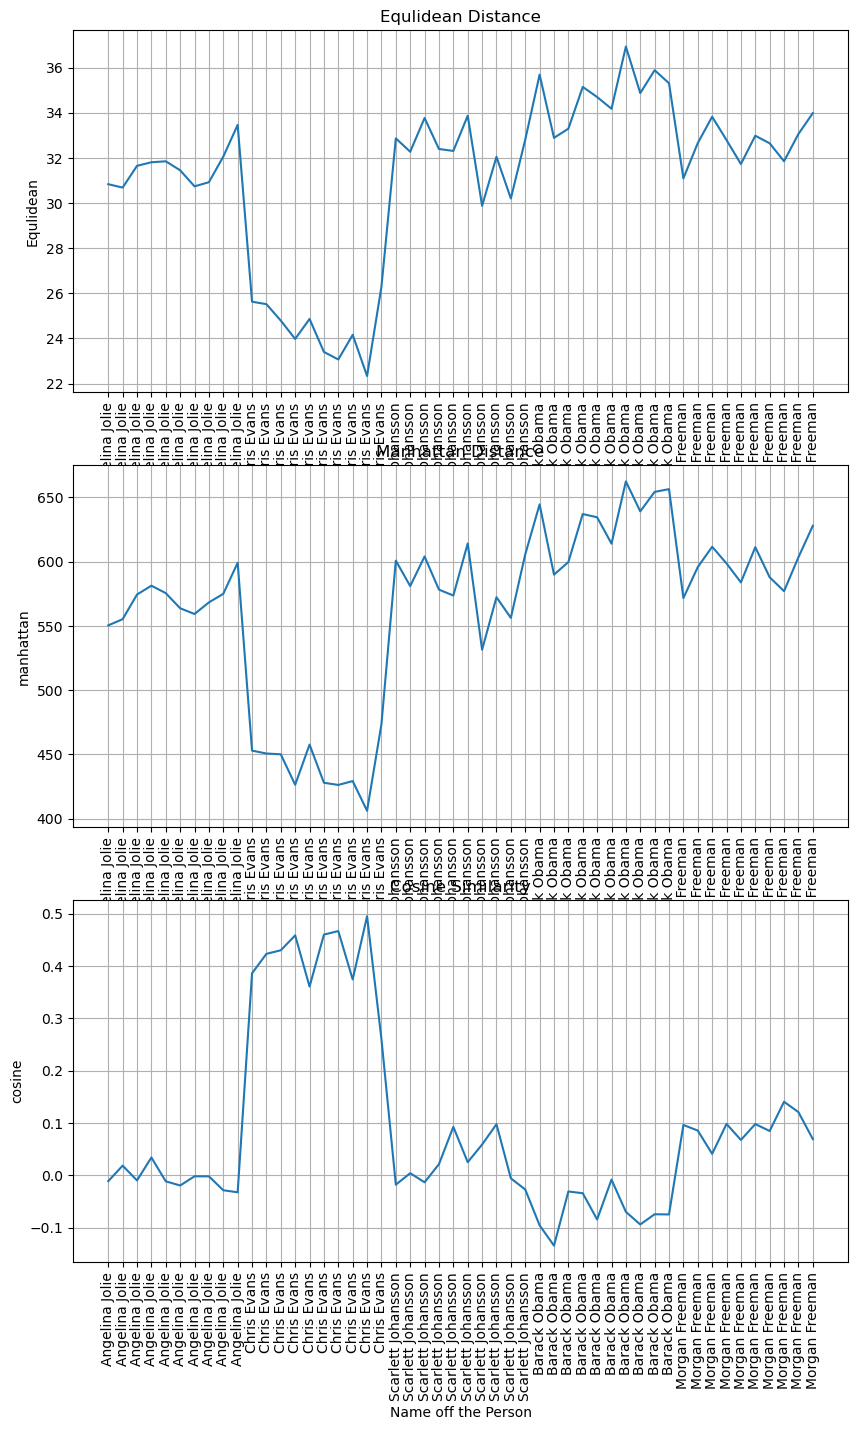

In [36]:
plt.figure(figsize=(10,16))
plt.subplot(3,1,1)
plt.plot(data_search['equlidean'],)
plt.xticks(ticks=list(range(len(data_search['equlidean']))), 
           labels=data_search['Name'], rotation=90)
plt.xlabel('Record Number')
plt.ylabel('Equlidean')
plt.title('Equlidean Distance')

plt.grid()


plt.subplot(3,1,2)
plt.plot(data_search['manhattan'],)
plt.xticks(ticks=list(range(len(data_search['manhattan']))), 
           labels=data_search['Name'], rotation=90)
plt.xlabel('Name off the Person')
plt.ylabel('manhattan')
plt.title('Manhattan Distance')

plt.grid()

plt.subplot(3,1,3)
plt.plot(data_search['cosine'],)
plt.xticks(ticks=list(range(len(data_search['cosine']))), 
           labels=data_search['Name'], rotation=90)
plt.xlabel('Name off the Person')
plt.ylabel('cosine')
plt.title('Cosine Similarity')
plt.grid()

plt.show()

### Có thể thấy ở 2 phương pháp sử dụng khoảng cách, thì khoảng cách của mẫu thử tới bộ đặc trưng của nhân vật Chris Evan là thấp nhất, trong khi ở phương pháp tương đồng cosine thì độ tương đồng tới Chris Evan cũng là lớn nhất (gần bằng 1)

### Nhận dạng bằng Khoảng cách Equlidean

In [37]:
d_eq_optimal = 25

In [38]:
datafilter = data_search.query(f'equlidean < {d_eq_optimal}')
datafilter.reset_index(drop=True,inplace=True)


if len(datafilter) > 0:
    argmin =  datafilter['equlidean'].argmin()
    name , role = datafilter.loc[argmin][['Name', 'Role']]
else:
    name = 'Unknown'
    role = 'Unknown'


In [39]:
print(name, role)

Chris Evans Student


### Nhận dạng bằng Khoảng cách Manhantan

In [40]:
d_man_optimal = 450

In [41]:
datafilter = data_search.query(f'manhattan < {d_man_optimal}')
datafilter.reset_index(drop=True,inplace=True)


if len(datafilter) > 0:
    argmin =  datafilter['manhattan'].argmin()
    name_man, role_man = datafilter.loc[argmin][['Name', 'Role']]
else:
    name_man = 'Unknown'
    role_man = 'Unknown'


In [42]:
print(name_man, role_man)

Chris Evans Student


### Nhận dạng bằng Độ tương đồng Cosine

In [43]:
S_opt = 0.4

In [44]:
datafilter = data_search.query(f'cosine > {S_opt}')
datafilter.reset_index(drop=True,inplace=True)


if len(datafilter) > 0:
    argmax =  datafilter['cosine'].argmax()
    name_cos , role_cos = datafilter.loc[argmax][['Name', 'Role']]
else:
    name_cos = 'Unknown'
    role_cos = 'Unknown'


In [45]:
print(name_cos, role_cos)

Chris Evans Student


### Phát hiện nhiều khuôn mặt trong 1 hình ảnh

In [48]:
def ml_search_algorithm(dataframe, feature_column, test_vector,
                        name_role=['Name', 'Role'], thresh=0.5):
#Phương thức sử dụng là độ tương đồng cosine
    # Bước 1: Lấy data frame
    dataframe = dataframe.copy()


    # Bước 2: Lấy tham số từ dataframe và đưa về 1 mảng
    X_list = dataframe[feature_column].tolist()
    x = np.asarray(X_list)
    
    # Bước 3: Tính toán độ tương đồng bằng cosine
    similar = pairwise.cosine_similarity(x,test_vector.reshape(1,-1))
    similar_arr = np.array(similar).flatten()
    dataframe['cosine'] = similar_arr
    # Bước 4: Lọc data
    data_filter = dataframe.query(f'cosine >= {thresh}')
    if len(data_filter) > 0:
        # Bước 5:  Xuất ra tên của những khuôn mặt nhận dạng được, không nhận dạng được sẽ ghi "Unknown
        data_filter.reset_index(drop=True, inplace=True)
        argmax = data_filter['cosine'].argmax()
        person_name, person_role = data_filter.loc[argmax][['Name', 'Role']]
    else: 
        person_name = 'Unknown'
        person_role = 'Unknown'

    return person_name, person_role

    


In [49]:
test_image = cv2.imread('test_images/test_7.jpeg')
cv2.imshow('test image', test_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [50]:
#Lấy hình ảnh test và áp dụng insightface
results = faceapp.get(test_image)
test_copy = test_image.copy()

#step 2: dùng vòng lặp dể phát hiện khuôn mặt và đưa tới hàm ml_search_algorithm
for res in results:
    x1, y1, x2, y2 = res['bbox'].astype(int)
    embeddings = res['embedding']
    person_name, person_role = ml_search_algorithm(dataframe, 'Facial_Features', 
                                                   test_vector = embeddings, 
                                                   name_role=['Name','Role'],
                                                   thresh=0.5)
    if person_name == 'Unknown':
        color = (0,0,255) 
    else:
        color = (0,255,0)
    
    cv2.rectangle(test_copy, (x1,y1), (x2, y2), color)
    text_gen =  person_name
    cv2.putText(test_copy,text_gen,(x1,y1), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 2)

cv2.imshow('test image', test_copy)
cv2.waitKey()
cv2.destroyAllWindows()

### Để tối ưu tốc độ thì chúng ta có thể nén 10 giá trị cho mỗi khuôn mặt đã nhận dạng được trong database thành 1 giá trị trung bình cho mỗi khuôn mặt.

In [53]:
dataframe_compress = dataframe.groupby(by=['Name', 'Role']).mean()
dataframe_compress.reset_index(inplace=True)
dataframe_compress

,Name,Role,Facial_Features
0,Angelina Jolie,Student,"[0.4324317, 1.074975, -0.12851736, -1.833421, ..."
1,Barack Obama,Teacher,"[0.94846946, -0.5583677, 0.09491567, -1.279613..."
2,Chris Evans,Student,"[0.72002447, -1.4682528, -0.77743137, -1.45999..."
3,Morgan Freeman,Teacher,"[0.48562637, -0.61965686, -0.4072629, 1.068597..."
4,Scarlett Johansson,Student,"[0.1912692, -0.48850536, -1.6902622, 0.4422732..."


#### Chuyển dataframe thành dạng mảng and và lưu ở định dạng numpy zip

In [54]:
xvalues = dataframe_compress.values

In [55]:
col_name = np.array(dataframe_compress.columns)
col_name

array(['Name', 'Role', 'Facial_Features'], dtype=object)

In [56]:
np.savez('dataframe_students_teacher.npz', xvalues, col_name)

In [57]:
# Load the numpy zip
file_np = np.load('dataframe_students_teacher.npz',allow_pickle=True)
file_np.files

['arr_0', 'arr_1']

In [58]:
pd.DataFrame(file_np['arr_0'], columns=file_np['arr_1'])

,Name,Role,Facial_Features
0,Angelina Jolie,Student,"[0.4324317, 1.074975, -0.12851736, -1.833421, ..."
1,Barack Obama,Teacher,"[0.94846946, -0.5583677, 0.09491567, -1.279613..."
2,Chris Evans,Student,"[0.72002447, -1.4682528, -0.77743137, -1.45999..."
3,Morgan Freeman,Teacher,"[0.48562637, -0.61965686, -0.4072629, 1.068597..."
4,Scarlett Johansson,Student,"[0.1912692, -0.48850536, -1.6902622, 0.4422732..."
